# Ejercicio 5: Verificacion de pronosticos

## ¿Cómo verificamos los pronósticos de las primeras semanas?

En este tutorial vamos a realizar una verificación temporal y espacial del pronóstico corregido y sin corregir de las primeras semanas del mes de marzi. Vamos a utilizar la metodología que utiliza el SMN para la verificación, pero para el dominio del sudeste de Sudamérica. Para ello, vamos a: 

* Elegir el dominio reducido.
* Tomar los datos diarios de precipitación correspondientes a las semanas 1 de pronóstico del mes de marzo y calcular el acumulado. 
* Tomar los datos diarios del ERA5 para las mismas semanas y calcular el acumulado. 
* Elegir dos umbrales de precipitación (5 y 30 mm, usados por el SMN) y calcular los elementos de una tabla de contingencia y los ínidices *Bias frec* (Bias en la frecuencia), *POD* (Probabilidad de detección) y *ETS* (*Equitable Threat Score*): 
* Graficar los resultados de una verificación temporal y espacial. 

Además de la librería para conectar con AWS, vamos a necesitar para este tutorial tener instalado las siguientes librerías:

netCDF4 : https://pypi.org/project/netCDF4/ numpy : https://pypi.org/project/numpy/ matplotlib : https://pypi.org/project/matplotlib/ cartopy : https://pypi.org/project/Cartopy/ pandas : https://pypi.org/project/Pandas/ pathlib : https://pypi.org/project/Pathlib/ datetime: https://pypi.org/project/datetime/


In [16]:
# Importamos las librerías que vamos a necesitar: 
%matplotlib inline

import s3fs
import netCDF4
import os
import numpy as np
import pandas as pd
import pathlib
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Definimos algunos parámetros:
variable = 'rain'
mes = 3
lat_n = -20
lat_s = -30
lon_w = -65
lon_e = -55

BUCKET_NAME = 'sissa-forecast-database'

**Pronósticos**

Como la estructura de los datos de los modelos de pronóstico (corregido y sin corregir) es igual, vamos a usar un 'for' para cargarlos, sin necesidad de descargar los archivos del AWS. Vamos a generar 2 archivos '.csv' con la información de las primeras semanas de pronóstico, sólo si estos no fueron generados previamente.  

In [17]:
tforecast = 'subseasonal'
modelos_gefs = ['GEFSv12_corr', 'GEFSv12']

for modelo in modelos_gefs:
    
    archivo_gefs = f"{modelo}_{variable}_2010_2019_mes{mes}_dom_{lon_e}_{lon_w}_{lat_n}_{lat_s}.csv"
    archivo_gefs = "py_"+archivo_gefs
    
    # Corremos esta parte del código sólo si los archivos no fueron generados previamente: 
    if not os.path.exists(archivo_gefs):
        df_total = pd.DataFrame()
        for year in range(2010, 2020):
            PATH0 = f"{tforecast}/{modelo}/{variable}/{year}/"
            print(PATH0)
            fs = s3fs.S3FileSystem(anon=True)
            # Listamos todos las carpetas dentro del bucket + PATH0:
            awsfolders = fs.ls('s3://' + BUCKET_NAME + '/' + PATH0)
            
            # Nos quedamos solo con las carpetas que corresponden al mes: 
            awsfolders = list(filter(lambda x: (str(year) + "{:02d}".format(mes)) in x, awsfolders))
            # Hay una carpeta por fecha de inicialización. 
            # Vemos cuáles son las fechas de inicialización: 
            fechas_inic = list(set([folder[-8:] for folder in awsfolders]))
            fechas_inic = sorted(fechas_inic)
            
            for fecha_inic in fechas_inic:
                print("Extrayendo datos de los archivos inicializados en:")
                print(fecha_inic)
                
                awsfiles = fs.ls('s3://' + BUCKET_NAME + '/' + PATH0 + fecha_inic + '/')
                # Nos quedamos solamente con la corrida control (por cuestiones de tiempo). 
                # Comentarear esta línea en caso de querer verificar todo el ensamble.
                awsfiles = [file for file in awsfiles if "c00" in file]
                
                for awsfile in awsfiles:
                    print("Extrayendo datos del archivo:")
                    print(awsfile)
                    
                    with fs.open(awsfile) as f:
                        with netCDF4.Dataset(awsfile, memory=f.read()) as gefs:
                            lon = gefs['lon'][:]
                            lat = gefs['lat'][:]
                            time = gefs['time'][:]
                            fecha_referencia = datetime.strptime('1900-01-01', '%Y-%m-%d')
                            fechas = [fecha_referencia + timedelta(days = int(intervalo)) for intervalo in time]
                            fechas = pd.to_datetime(fechas, format = '%Y%m%d')
                            print(fechas)
                            
                            lon_idx = np.where((lon >= lon_w) & (lon <= lon_e))[0]
                            lat_idx = np.where((lat >= lat_s) & (lat <= lat_n))[0]
                            lon_rec = lon[lon_idx]
                            lat_rec = lat[lat_idx]
                            
                            var = gefs[variable][:]
                            var.shape # Dimensiones: tiempo, lat, lon.
                            
                            # Hacemos un recorte en el dominio: 
                            var_rec = var[:, lat_idx[0]:lat_idx[-1]+1, lon_idx[0]:lon_idx[-1]+1]
                            # Hacemos el acumulado de la primer semana de pronóstico. 
                            # Calcular la media en caso de trabajar con la temperatura.
                            suma = np.sum(var_rec[:7, :, :], axis=(0))
                            
                            if awsfiles.index(awsfile) == 0:
                                gvar = np.empty((len(lat_rec), len(lon_rec), len(awsfiles)))
                            
                            gvar[:, :, awsfiles.index(awsfile)] = suma
                
                # Calculamos la media del ensamble:
                # En este caso elegimos solo la corrida control, así que la media  
                # va a ser igual a los datos originales. 
                media = np.mean(gvar, axis = 2)
                
                # Guardamos la información en un data.frame: 
                df = pd.DataFrame({
                    'lat': np.repeat(lat_rec, len(lon_rec)),
                    'lon': np.tile(lon_rec, len(lat_rec)),
                    'acum': media.flatten()
                })
                df['fecha_inic'] = pd.to_datetime(fecha_inic, format = '%Y%m%d')
                
                df_total = pd.concat([df_total, df], ignore_index = True)
        
        # Guardamos la información en un archivo '.csv':
        df_total.to_csv(archivo_gefs, sep = ';', index = False)


Cargamos los archivos ".csv" generados.

In [18]:
df_total_corr = pd.read_csv("py_"+f"GEFSv12_corr_{variable}_2010_2019_mes{mes}_dom_{lon_e}_{lon_w}_{lat_n}_{lat_s}.csv", sep = ';')
df_total_corr['fecha_inic'] = pd.to_datetime(df_total_corr['fecha_inic'])

df_total_sincorr = pd.read_csv("py_"+f"GEFSv12_{variable}_2010_2019_mes{mes}_dom_{lon_e}_{lon_w}_{lat_n}_{lat_s}.csv", sep = ';')
df_total_sincorr['fecha_inic'] = pd.to_datetime(df_total_sincorr['fecha_inic'])

**ERA5**

Vamos a hacer un procedimiento análogo para los datos de ERA5. Vamos a generar un archivo '.csv' con la información de las mismas semanas, sólo si este no fue generado previamente.

In [19]:
modelo = 'ERA5'
archivo_obs = "py_"+f"{modelo}_{variable}_2010_2019_mes{mes}_dom{lon_e}{lon_w}{lat_n}{lat_s}.csv"

# Corremos esta parte del código sólo si el archivo no fue generado previamente:   
if not os.path.exists(archivo_obs):
    df_total = pd.DataFrame()
    for year in range(2010, 2020):
        PATH0 = f"{modelo}/{variable}/{year}"+".nc"
        print(PATH0)
        fs = s3fs.S3FileSystem(anon=True)
        # Listamos el archivo dentro del bucket + PATH0:
        awsfile = fs.ls('s3://' + BUCKET_NAME + '/' + PATH0)
            
        print("Extrayendo datos del archivo:")
        print(awsfile)
        
        with fs.open(awsfile[0]) as f:
            with netCDF4.Dataset(awsfile[0], memory=f.read()) as era5:
                lon = era5['longitude'][:]
                lat = era5['latitude'][:]
                time = era5['time'][:]
                fecha_referencia = datetime.strptime('1900-01-01', '%Y-%m-%d')
                fechas = [fecha_referencia + timedelta(days = int(intervalo)) for intervalo in time]
                fechas =  pd.to_datetime(fechas, format = '%Y%m%d')           
                print(fechas)
                            
                lon_idx = np.where((lon >= lon_w) & (lon <= lon_e))[0]
                lat_idx = np.where((lat >= lat_s) & (lat <= lat_n))[0]
                lon_rec = lon[lon_idx]
                lat_rec = lat[lat_idx]
                            
                var = era5[variable][:]
                var.shape # Dimensiones: time, lat, lon. 
                
                # Hacemos un recorte en el dominio: 
                var_rec = var[:, lat_idx[0]:lat_idx[-1]+1, lon_idx[0]:lon_idx[-1]+1]
                
                # Vemos las fechas de inicialización de "df_total_corr" para ese año y mes.
                # A partir de ellas, vamos a calcular el acumulado observado a una semana: 
                fechas_inic = df_total_corr[df_total_corr['fecha_inic'].dt.year == year]['fecha_inic'].unique()
                fechas_inic = pd.to_datetime(fechas_inic, format = '%Y%m%d')
                
                for fecha_inic in fechas_inic:
                    aux_inic = np.where(fechas == fecha_inic)[0][0]
                    
                    # Hacemos el recorte desde la fecha de inicialización hasta la primer semana,
                    # solo si el día final de la primer semana está incluido en el archivo
                    # (esto puede no pasar para el mes de diciembre):
                    # Por ejemplo, puede pasar que la fecha de inicialización del 
                    # pronóstico sea el 31-12-2010, por lo que no se va a poder 
                    # caluclar el acumulado semanal de la primer semana asociada a dicha
                    # fecha de inicialización.
                    if (aux_inic + 6) >= var_rec.shape[0]:
                        continue
                    # Hacemos el recorte de la primer semana que empieza con la fecha de inicialización: 
                    var_rec2 = var_rec[aux_inic:(aux_inic + 6),:,:]
                    
                    # Hacemos el acumulado de la primer semana que empieza con la fecha de inicialización: 
                    # Calcular la media en caso de trabajar con la temperatura.
                    suma = np.sum(var_rec2, axis=(0))
                    
                    # Guardamos la información en un data.frame: 
                    df = pd.DataFrame({
                        'lat': np.repeat(lat_rec, len(lon_rec)),
                        'lon': np.tile(lon_rec, len(lat_rec)),
                        'acum': suma.flatten()
                        })
                    df['fecha_inic'] = pd.to_datetime(fecha_inic, format = '%Y%m%d')
                    
                    df_total = pd.concat([df_total, df], ignore_index = True)
    
    # Guardamos la información en un archivo '.csv':
    df_total.to_csv(archivo_obs, sep = ';', index = False)

In [20]:
# Cargamos el archivo ".csv" generado:
df_total_obs = pd.read_csv("py_"+f"ERA5_{variable}_2010_2019_mes{mes}_dom{lon_e}{lon_w}{lat_n}{lat_s}.csv", sep = ';')
df_total_obs['fecha_inic'] = pd.to_datetime(df_total_obs['fecha_inic'])

Juntamos en un único DataFrame la información pronosticada y del ERA5.

In [21]:
# Hacemos un merge de df_total_corr y df_total_sincorr:
df_total = pd.merge(df_total_corr, df_total_sincorr, 
                    on = ["lon", "lat", "fecha_inic"], suffixes=("_corr", "_sincorr"))

# Hacemos un merge de df_total_obs y df_total:
df_total = pd.merge(df_total_obs, df_total, 
                    on = ["lon", "lat", "fecha_inic"])

# Eliminamos las filas con valores faltantes:
# Esto va a eliminar la fila con fecha de inicialización cuya primer semana
# no estuvo contemplada.    
df_total.dropna(inplace = True)

# Eliminamos los data.frames originales para liberar memoria:
del df_total_obs, df_total_corr, df_total_sincorr

Definimos una función para calcular los elementos de una tabla de contingencia:

- *Hits*: Cantidad de casos en los cuales la observación y el pronóstico superaron el umbral.  
- *False Alarms*: Cantidad de casos en los cuales el pronóstico superó el umbral pero la observación no.
- *Missed events*: Cantidad de casos en los cuales la observación superó el umbral pero el pronóstico no. 
- *Correct negatives*: Cantidad de casos en los cuales la observación ni el pronóstico superaron el umbral.

También la función calcula los siguientes índices de verificación, a partir de estos elementos:

- **Bias en la frecuencia**: Compara las frecuencias pronosticadas con las observadas.
- **Probabilidad de detección (POD)**: Indica la proporción de casos observados que sí fueron pronosticados. 
- **ETS o Equitable Threat Score**: Mide la proporción de aciertos pero ajustado por la cantidad de aciertos que fueron aleatorios. 

In [22]:
def funcion_tabla_cont(observacion, pronostico, umbral):
    # Creamos vectores lógicos para los valores que superan el umbral:
    obs_sup_umbral = observacion > umbral
    prono_sup_umbral = pronostico > umbral
    
    # Calculamos los hits, false_alarms, missed_events y correct_negatives:
    hits = np.sum(obs_sup_umbral & prono_sup_umbral)
    false_alarms = np.sum(~obs_sup_umbral & prono_sup_umbral)
    missed_events = np.sum(obs_sup_umbral & ~prono_sup_umbral)
    correct_negatives = np.sum(~obs_sup_umbral & ~prono_sup_umbral)
    
    total_events_observed = hits + missed_events
    total_non_events_observed = false_alarms + correct_negatives
    total_events_forecast = hits + false_alarms
    total_non_events_forecast = missed_events + correct_negatives
    total = hits + false_alarms + missed_events + correct_negatives
    
    # Calculamos los índices bias_fec, pod y ets:  
    bias_frec = total_events_forecast / total_events_observed
    pod = hits / total_events_observed
    far = false_alarms / total_events_forecast
    
    random_hits = (total_events_forecast * total_events_observed) / total
    ets = (hits - random_hits) / (hits + false_alarms + missed_events - random_hits)
    
    return {'hits': hits, 'false_alarm': false_alarms, 
            'missed_events': missed_events, 'correct_negatives': correct_negatives, 
            'bias_frec': bias_frec, 'pod': pod, 'far': far, 'ets': ets}

## Verificación temporal

Calculamos los índices por año, considerando todo el dominio. 

In [23]:
# Definimos umbrales:
umbrales = [5, 30]

tabla_total_corr = pd.DataFrame()
tabla_total_sincorr = pd.DataFrame()

# Iteramos sobre cada umbral y año:
for umbral in umbrales:
    for j in range(2010, 2020):
        df_anio = df_total[df_total['fecha_inic'].dt.year == j]
        
        # Calculamos la tabla de contingencia para el pronóstico corregido y sin corregir:
        tabla_corr = funcion_tabla_cont(observacion = df_anio['acum'], pronostico = df_anio['acum_corr'], umbral = umbral)
        tabla_corr = pd.concat([pd.DataFrame({'umbral': [umbral], 'anio': [j]}), pd.DataFrame(tabla_corr, index = [0])], axis = 1)
        tabla_total_corr = pd.concat([tabla_total_corr, tabla_corr], ignore_index = True)
        
        tabla_sincorr = funcion_tabla_cont(observacion = df_anio['acum'], pronostico = df_anio['acum_sincorr'], umbral = umbral)
        tabla_sincorr = pd.concat([pd.DataFrame({'umbral': [umbral], 'anio': [j]}), pd.DataFrame(tabla_sincorr, index = [0])], axis = 1)
        tabla_total_sincorr = pd.concat([tabla_total_sincorr, tabla_sincorr], ignore_index = True)   

Graficamos las series temporales, sólo para el umbral de 30 mm.

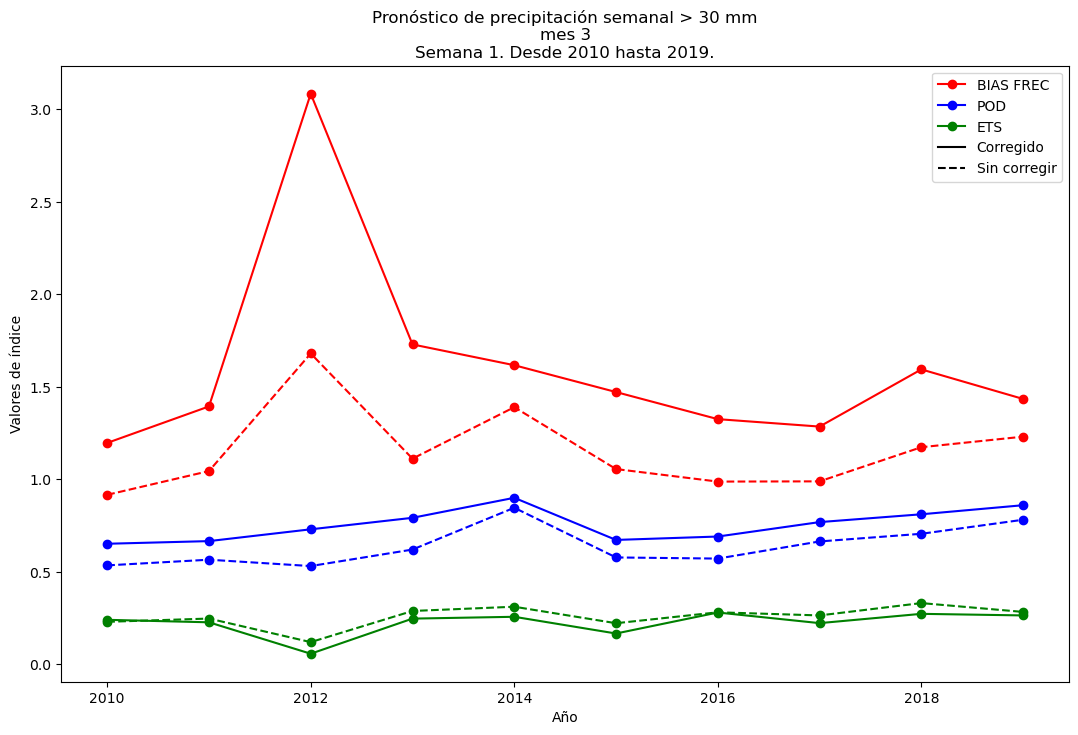

In [24]:
# Elegimos solo un umbral: 
umbral = 30
tabla_corr = tabla_total_corr[tabla_total_corr['umbral'] == umbral]
tabla_sincorr = tabla_total_sincorr[tabla_total_sincorr['umbral'] == umbral]

plt.figure(figsize = (13, 8))

# Bias_frec prono corregido:
plt.plot(tabla_corr['anio'], tabla_corr['bias_frec'], 'ro')
plt.plot(tabla_corr['anio'], tabla_corr['bias_frec'], 'r-', linewidth = 1.5)
# Bias_frec prono sin corregir:
plt.plot(tabla_sincorr['anio'], tabla_sincorr['bias_frec'], 'ro')
plt.plot(tabla_corr['anio'], tabla_sincorr['bias_frec'], 'r--', linewidth = 1.5)
# POD prono corregido:
plt.plot(tabla_corr['anio'], tabla_corr['pod'], 'bo')
plt.plot(tabla_corr['anio'], tabla_corr['pod'], 'b-', linewidth = 1.5)
# POD prono sin corregir:
plt.plot(tabla_sincorr['anio'], tabla_sincorr['pod'], 'bo')
plt.plot(tabla_sincorr['anio'], tabla_sincorr['pod'], 'b--', linewidth = 1.5)
# ETS prono corregido:
plt.plot(tabla_corr['anio'], tabla_corr['ets'], 'go')
plt.plot(tabla_corr['anio'], tabla_corr['ets'], 'g-', linewidth = 1.5)
# ETS prono sin corregir:
plt.plot(tabla_sincorr['anio'], tabla_sincorr['ets'], 'go')
plt.plot(tabla_sincorr['anio'], tabla_sincorr['ets'], 'g--', linewidth = 1.5)

# Para crear la leyenda: 
handles, labels = plt.gca().get_legend_handles_labels()
patch1 = Line2D([0], [0], color = 'red', marker = 'o', label = 'BIAS FREC')
patch2 = Line2D([0], [0], color = 'blue', marker = 'o', label = 'POD')
patch3 = Line2D([0], [0], color = 'green', marker = 'o', label = 'ETS')
line1 = Line2D([0], [0], color = 'black', label = 'Corregido')
line2 = Line2D([1], [0], color = 'black', label = 'Sin corregir', linestyle = '--')
handles.extend([patch1, patch2, patch3, line1, line2])
plt.legend(handles = handles)

plt.xlabel('Año')
plt.ylabel('Valores de índice')
plt.title(f'Pronóstico de precipitación semanal > {umbral} mm\nmes {mes}\nSemana 1. Desde 2010 hasta 2019.')

# Guardamos la figura:
plt.savefig(f"serie_temporal_verif_{variable}_2010_2019_mes{mes}_dom_{lon_e}_{lon_w}_{lat_n}_{lat_s}.jpg", dpi = 130)

# Mostramos el plot:
plt.show()

## Verificación espacial

Calculamos los índices por punto de retícula, considerando todos los años. 

In [25]:
umbrales = [5, 30]
tabla_total_corr = pd.DataFrame()
tabla_total_sincorr = pd.DataFrame()

# Iteramos sobre cada umbral y punto de retícula:
for umbral in umbrales:
    ptos_reticula = df_total[['lon', 'lat']].drop_duplicates()
    for i in range(len(ptos_reticula)):
        lon_pto = ptos_reticula.iloc[i]['lon']
        lat_pto = ptos_reticula.iloc[i]['lat']
        
        df_pto_reticula = df_total[(df_total['lon'] == lon_pto) & (df_total['lat'] == lat_pto)]

        tabla_corr = funcion_tabla_cont(observacion = df_pto_reticula['acum'], pronostico = df_pto_reticula['acum_corr'], umbral = umbral)
        tabla_corr = pd.concat([pd.DataFrame({'umbral': [umbral], 'lon': [lon_pto], 'lat': [lat_pto]}), pd.DataFrame(tabla_corr, index = [0])], axis = 1)
        tabla_total_corr = pd.concat([tabla_total_corr, tabla_corr])

        tabla_sincorr = funcion_tabla_cont(observacion = df_pto_reticula['acum'], pronostico = df_pto_reticula['acum_sincorr'], umbral = umbral)
        tabla_sincorr = pd.concat([pd.DataFrame({'umbral': [umbral], 'lon': [lon_pto], 'lat': [lat_pto]}), pd.DataFrame(tabla_sincorr, index = [0])], axis = 1)
        tabla_total_sincorr = pd.concat([tabla_total_sincorr, tabla_sincorr])

C:\Users\fcarrasco\AppData\Local\Temp\ipykernel_19648\2456609885.py:24: RuntimeWarning: invalid value encountered in scalar divide
  ets = (hits - random_hits) / (hits + false_alarms + missed_events - random_hits)
C:\Users\fcarrasco\AppData\Local\Temp\ipykernel_19648\2456609885.py:24: RuntimeWarning: invalid value encountered in scalar divide
  ets = (hits - random_hits) / (hits + false_alarms + missed_events - random_hits)
C:\Users\fcarrasco\AppData\Local\Temp\ipykernel_19648\2456609885.py:24: RuntimeWarning: invalid value encountered in scalar divide
  ets = (hits - random_hits) / (hits + false_alarms + missed_events - random_hits)
C:\Users\fcarrasco\AppData\Local\Temp\ipykernel_19648\2456609885.py:24: RuntimeWarning: invalid value encountered in scalar divide
  ets = (hits - random_hits) / (hits + false_alarms + missed_events - random_hits)
C:\Users\fcarrasco\AppData\Local\Temp\ipykernel_19648\2456609885.py:24: RuntimeWarning: invalid value encountered in scalar divide
  ets = (hits

Graficamos los campos espaciales, sólo para el umbral de 30 mm.

<Figure size 3000x2500 with 0 Axes>

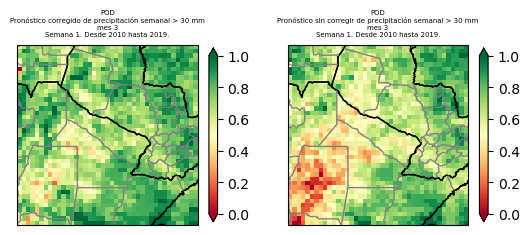

In [26]:
# Cargamos los paises y estados/provincias:
countries = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries',
        scale='10m',
        facecolor='none')
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

# Elegimos solo un umbral:
umbral = 30
tabla_corr = tabla_total_corr[tabla_total_corr['umbral'] == umbral]
tabla_sincorr = tabla_total_sincorr[tabla_total_sincorr['umbral'] == umbral]

# Usamos 'pivot_table' para convertir "tabla_corr" y "tabla_sincorr" en matrices 2D con formato wide: 
tabla_corr = tabla_corr.pivot_table(index = 'lat', columns = 'lon', values = 'pod')
tabla_sincorr = tabla_sincorr.pivot_table(index = 'lat', columns = 'lon', values = 'pod')

plt.figure(figsize = (30, 25))
fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw = {'projection': ccrs.PlateCarree()})

# Pronóstico corregido:
cs = ax[0].pcolormesh(tabla_corr.columns, tabla_corr.index, tabla_corr, transform = ccrs.PlateCarree(), vmin = 0, vmax = 1, cmap = 'RdYlGn')
ax[0].coastlines()
ax[0].add_feature(countries, edgecolor = 'black')
ax[0].add_feature(states_provinces, edgecolor = 'gray')
cb = fig.colorbar(cs, ax = ax[0], shrink = 0.47, extend = 'both')
ax[0].set_title("POD\nPronóstico corregido de precipitación semanal > " + str(umbral) + " mm\n" + "mes " + str(mes) + "\n" + "Semana 1. Desde 2010 hasta 2019.", fontsize = 5)

# Pronóstico sin corregir:
cs = ax[1].pcolormesh(tabla_sincorr.columns, tabla_sincorr.index, tabla_sincorr, transform = ccrs.PlateCarree(), vmin = 0, vmax = 1, cmap = 'RdYlGn')
ax[1].coastlines()
ax[1].add_feature(countries, edgecolor = 'black')
ax[1].add_feature(states_provinces, edgecolor = 'gray')
cb = fig.colorbar(cs, ax = ax[1], shrink = 0.47, extend = 'both')
ax[1].set_title("POD\nPronóstico sin corregir de precipitación semanal > " + str(umbral) + " mm\n" + "mes " + str(mes) + "\n" + "Semana 1. Desde 2010 hasta 2019.", fontsize = 5)

# Guardamos la figura:
plt.savefig(f"pod_{variable}_2010_2019_mes{mes}_dom_{lon_e}_{lon_w}_{lat_n}_{lat_s}.jpg", dpi = 199, bbox_inches = 'tight')
